In [1]:
import torch

if torch.backends.mps.is_available():
    print("Running on Apple M1/M2 GPU (MPS backend).")
elif torch.cuda.is_available():
    print("Running on NVIDIA GPU.")
else:
    print("Running on CPU.")


Running on NVIDIA GPU.


In [11]:
pip install opencv-python opencv-python-headless

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [46]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [48]:
# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "./PKLot"
CLASSES_LIST = ["Occupied", "Vacant"]
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
torch.manual_seed(seed_constant)

In [49]:
# Preprocessing constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20

In [ ]:
# Dataset Class
class PKLotDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, sequence_length=SEQUENCE_LENGTH):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_sequence = self.image_sequence_extraction(self.image_paths[index])
        label = self.labels[index]
        return torch.tensor(image_sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        
    def image_sequence_extraction(self, image_path):
        frames_list = []
        image_files = os.listdir(image_path)
        skip_images = max(int(len(image_files) / self.sequence_length), 1)

        for i in range(self.sequence_length):
            image_index = i * skip_images
            if image_index >= len(image_files):
                break
            img_path = os.path.join(image_path, image_files[image_index])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            frames_list.append(image)
        return frames_list


In [37]:
# Define the transforms for the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [45]:
# Function to extract, resize, and normalize image sequences
def image_sequence_extraction(image_paths, sequence_length=SEQUENCE_LENGTH):
    image_sequence = []
    skip_frames_window = max(int(len(image_paths) / sequence_length), 1)

    for frame_counter in range(sequence_length):
        image_path = image_paths[frame_counter * skip_frames_window]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_frame = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        image_sequence.append(normalized_frame)

    return np.array(image_sequence)

In [52]:
# Dataset Creation Function
def create_dataset():
    image_paths = []
    labels = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        class_dir = os.path.join(DATASET_DIR, class_name)
        if not os.path.isdir(class_dir):
            continue
        for folder_name in os.listdir(class_dir):
            folder_path = os.path.join(class_dir, folder_name)
            if os.path.isdir(folder_path):
                image_paths.append(folder_path)
                labels.append(class_index)
    return image_paths, labels

In [53]:
# Load images and labels from the PKLot dataset directory
dataset_dir = './'
image_paths = []
labels = []

for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))
            labels.append(0)  # Placeholder label

In [39]:
# Split the dataset into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=seed_constant)

In [54]:
# Create dataset objects
train_dataset = PKLotDataset(train_paths, train_labels, transform=transform)
val_dataset = PKLotDataset(val_paths, val_labels, transform=transform)

In [55]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [56]:
# Visualization of random images from the dataset
plt.figure(figsize=(20, 20))
random_indices = random.sample(range(len(image_paths)), 20)

<Figure size 2000x2000 with 0 Axes>

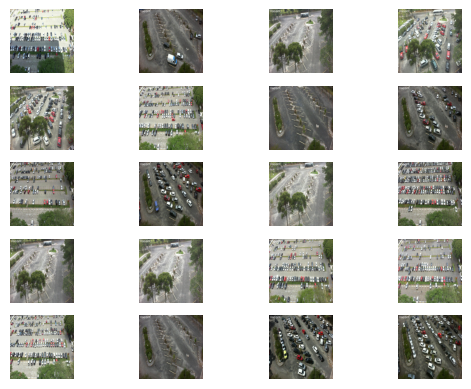

In [57]:
for counter, idx in enumerate(random_indices, 1):
    image_path = image_paths[idx]
    label = "Occupied" if labels[idx] == 1 else "Vacant"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter)
    plt.imshow(image)
    plt.axis('off')

plt.show()
